In [ ]:
# Kaggle default setup code

# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import pandas as pd
import torch
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

base_path = "/kaggle/input"
emotion_map = {
    'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3,
    'neutral': 4, 'ps': 5, 'sad': 6  # ps = pleasant surprise
}

2025-08-05 15:29:40.196686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754407780.596010      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754407780.705310      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
audio_paths = []
labels = []
seen_filenames = set()

for root, _, files in os.walk(base_path):
    for file in files:


        if file.endswith(".wav"):
            filename = os.path.basename(file)
            if filename in seen_filenames:
                continue  # Skip duplicates
            seen_filenames.add(filename)

            label_str = filename.split('_')[-1].split('.')[0].lower()
            if label_str in emotion_map:
                full_path = os.path.join(root, file)
                audio_paths.append(full_path)
                labels.append(emotion_map[label_str])

        # early stopping for safety
        if len(audio_paths) >= 2800:
            break
    if len(audio_paths) >= 2800:
        break

print(f"Loaded {len(audio_paths)} unique files.")

df = pd.DataFrame({'audio_path': audio_paths, 'label': labels})
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


Loaded 2800 unique files.


In [ ]:
# ========== STEP 2: Train-Test Split ==========
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [ ]:
# ========== STEP 3: Loading Processor ==========
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
# ========== STEP 4: Custom Dataset Class ==========
class TESSDataset(Dataset):
    def __init__(self, df, processor, max_length=16000*4):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]["audio_path"]
        label = self.df.iloc[idx]["label"]
        speech, sr = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)))

        inputs = self.processor(speech, sampling_rate=16000, return_tensors="pt", padding=True, truncation=False)
        return {
            'input_values': inputs.input_values.squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TESSDataset(train_df, processor)
test_dataset = TESSDataset(test_df, processor)

In [ ]:
# ========== STEP 5: Loading Model ==========
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=7,  # TESS has 7 classes
    problem_type="single_label_classification"
)

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ========== STEP 6: Training Arguments ==========
training_args = TrainingArguments(
    output_dir="./tess-wav2vec2-checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    logging_dir="./logs",
    report_to=[],
)


In [ ]:
# ========== STEP 7: Metrics ==========
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
# ========== STEP 8: Trainer Setup ==========
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

In [ ]:
# ========== STEP 9: Train and Save ==========
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.468252,1.000000,1.000000,1.000000,1.000000
2,No log,0.139840,1.000000,1.000000,1.000000,1.000000
3,No log,0.082839,1.000000,1.000000,1.000000,1.000000
4,0.485400,0.071250,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=560, training_loss=0.44241891758782526, metrics={'train_runtime': 1499.8172, 'train_samples_per_second': 5.974, 'train_steps_per_second': 0.373, 'total_flos': 3.2538261504e+17, 'train_loss': 0.44241891758782526, 'epoch': 4.0})

In [ ]:
# Saving model and processor for fine-tuning on RAVDESS
model.save_pretrained("/kaggle/working/tess-pretrained-model")
processor.save_pretrained("/kaggle/working/tess-pretrained-model")

[]

In [ ]:
# Zipping the entire folder
!zip -r /kaggle/working/tess-pretrained-model.zip /kaggle/working/tess-pretrained-model


  adding: kaggle/working/tess-pretrained-model/ (stored 0%)
  adding: kaggle/working/tess-pretrained-model/special_tokens_map.json (deflated 45%)
  adding: kaggle/working/tess-pretrained-model/vocab.json (deflated 55%)
  adding: kaggle/working/tess-pretrained-model/tokenizer_config.json (deflated 71%)
  adding: kaggle/working/tess-pretrained-model/model.safetensors (deflated 7%)
  adding: kaggle/working/tess-pretrained-model/preprocessor_config.json (deflated 38%)
  adding: kaggle/working/tess-pretrained-model/config.json (deflated 67%)


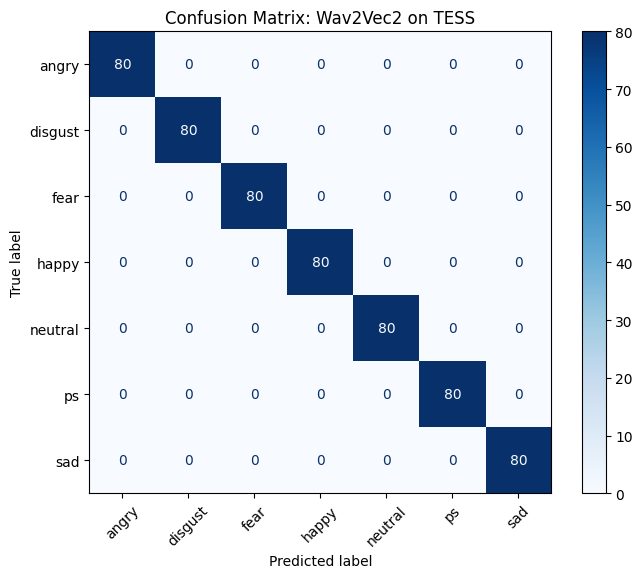

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Wav2Vec2 on TESS")
plt.show()


In [ ]:
import random
from IPython.display import Audio

i = random.randint(0, len(test_dataset)-1)
sample = test_dataset[i]
input_values = sample['input_values'].unsqueeze(0).to(model.device)

with torch.no_grad():
    logits = model(input_values).logits
predicted = logits.argmax(dim=-1).item()

print(f"True Label: {sample['labels'].item()}")
print(f"Predicted Label: {predicted}")
Audio(sample['input_values'].cpu().numpy(), rate=16000)


True Label: 4
Predicted Label: 4
